In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

import time

start_time = time.time()
tcurrent   = start_time

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 993 # original seed: 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:31<00:00,  4.42it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 56.60it/s]

Done!


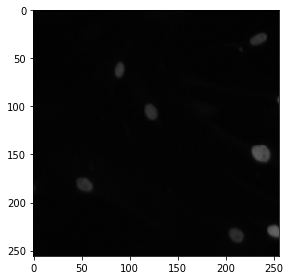

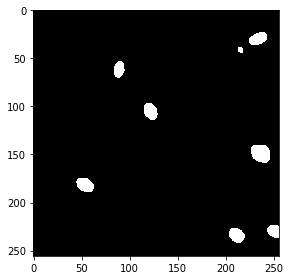

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [6]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p5)
c6 = Dropout(0.3) (c6)
c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
p6 = MaxPooling2D(pool_size=(2, 2)) (c6)

c7 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p6)
c7 = Dropout(0.3) (c7)
c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c6])
c8 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c5])
c9 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.2) (c9)
c9 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c4])
c10 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.2) (c10)
c10 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c10)

u11 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = concatenate([u11, c3])
c11 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u11)
c11 = Dropout(0.2) (c11)
c11 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c11)

u12 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c11)
u12 = concatenate([u12, c2])
c12 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u12)
c12 = Dropout(0.1) (c12)
c12 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c12)

u13 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c12)
u13 = concatenate([u13, c1], axis=3)
c13 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u13)
c13 = Dropout(0.1) (c13)
c13 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c13)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c13)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 256, 256, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 16)  448         lambda_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256, 256, 16)  0           conv2d_1[0][0]                   
___________________________________________________________________________________________

In [7]:
# Fit model
earlystopper = EarlyStopping(patience=30, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)

# setup
n_epochs  = 100
val_split = 0.15

# fitting
results = model.fit(X_train, Y_train, validation_split=val_split, batch_size=32, epochs=n_epochs, 
                    callbacks=[earlystopper, checkpointer])

Train on 569 samples, validate on 101 samples
Epoch 1/100
569/569 [==============================] - 42s - loss: 0.6694 - mean_iou: 0.3996 - val_loss: 0.5970 - val_mean_iou: 0.4246
Epoch 2/100
569/569 [==============================] - 29s - loss: 0.5231 - mean_iou: 0.4254 - val_loss: 0.3579 - val_mean_iou: 0.4246
Epoch 3/100
569/569 [==============================] - 29s - loss: 0.3338 - mean_iou: 0.4247 - val_loss: 0.2629 - val_mean_iou: 0.4246
Epoch 4/100
569/569 [==============================] - 29s - loss: 0.2634 - mean_iou: 0.4247 - val_loss: 0.2565 - val_mean_iou: 0.4267
Epoch 5/100
569/569 [==============================] - 29s - loss: 0.2212 - mean_iou: 0.4317 - val_loss: 0.1867 - val_mean_iou: 0.4399
Epoch 6/100
569/569 [==============================] - 29s - loss: 0.2120 - mean_iou: 0.4478 - val_loss: 0.1682 - val_mean_iou: 0.4560
Epoch 7/100
569/569 [==============================] - 27s - loss: 0.1841 - mean_iou: 0.4667 - val_loss: 0.1841 - val_mean_iou: 0.4815
Epoch 8/1

569/569 [==============================] - 27s - loss: 0.0728 - mean_iou: 0.7559 - val_loss: 0.0712 - val_mean_iou: 0.7575
Epoch 33/100
569/569 [==============================] - 27s - loss: 0.0702 - mean_iou: 0.7591 - val_loss: 0.0683 - val_mean_iou: 0.7606
Epoch 34/100
569/569 [==============================] - 29s - loss: 0.0697 - mean_iou: 0.7622 - val_loss: 0.0672 - val_mean_iou: 0.7637
Epoch 35/100
569/569 [==============================] - 29s - loss: 0.0699 - mean_iou: 0.7651 - val_loss: 0.0633 - val_mean_iou: 0.7665
Epoch 36/100
569/569 [==============================] - 27s - loss: 0.0693 - mean_iou: 0.7679 - val_loss: 0.0637 - val_mean_iou: 0.7692
Epoch 37/100
569/569 [==============================] - 27s - loss: 0.0687 - mean_iou: 0.7705 - val_loss: 0.0651 - val_mean_iou: 0.7717
Epoch 38/100
569/569 [==============================] - 27s - loss: 0.0700 - mean_iou: 0.7729 - val_loss: 0.0653 - val_mean_iou: 0.7741
Epoch 39/100
569/569 [==============================] - 27s -

569/569 [==============================] - 27s - loss: 0.0641 - mean_iou: 0.8107 - val_loss: 0.0593 - val_mean_iou: 0.8111
Epoch 63/100
569/569 [==============================] - 27s - loss: 0.0628 - mean_iou: 0.8116 - val_loss: 0.0602 - val_mean_iou: 0.8121
Epoch 64/100
569/569 [==============================] - 27s - loss: 0.0628 - mean_iou: 0.8126 - val_loss: 0.0623 - val_mean_iou: 0.8131
Epoch 65/100
569/569 [==============================] - 27s - loss: 0.0640 - mean_iou: 0.8136 - val_loss: 0.0613 - val_mean_iou: 0.8140
Epoch 66/100
569/569 [==============================] - 27s - loss: 0.0615 - mean_iou: 0.8145 - val_loss: 0.0593 - val_mean_iou: 0.8149
Epoch 67/100
569/569 [==============================] - 27s - loss: 0.0618 - mean_iou: 0.8154 - val_loss: 0.0629 - val_mean_iou: 0.8158
Epoch 68/100
569/569 [==============================] - 27s - loss: 0.0655 - mean_iou: 0.8163 - val_loss: 0.0608 - val_mean_iou: 0.8167
Epoch 69/100
569/569 [==============================] - 29s -

569/569 [==============================] - 27s - loss: 0.0587 - mean_iou: 0.8337 - val_loss: 0.0583 - val_mean_iou: 0.8339
Epoch 94/100
569/569 [==============================] - 29s - loss: 0.0565 - mean_iou: 0.8342 - val_loss: 0.0574 - val_mean_iou: 0.8345
Epoch 95/100
569/569 [==============================] - 27s - loss: 0.0550 - mean_iou: 0.8348 - val_loss: 0.0583 - val_mean_iou: 0.8351
Epoch 96/100
569/569 [==============================] - 27s - loss: 0.0550 - mean_iou: 0.8354 - val_loss: 0.0595 - val_mean_iou: 0.8356
Epoch 97/100
569/569 [==============================] - 27s - loss: 0.0547 - mean_iou: 0.8359 - val_loss: 0.0610 - val_mean_iou: 0.8361
Epoch 98/100
569/569 [==============================] - 27s - loss: 0.0552 - mean_iou: 0.8364 - val_loss: 0.0581 - val_mean_iou: 0.8366
Epoch 99/100
569/569 [==============================] - 27s - loss: 0.0548 - mean_iou: 0.8369 - val_loss: 0.0605 - val_mean_iou: 0.8372
Epoch 100/100
569/569 [==============================] - 27s 

In [8]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 1s     


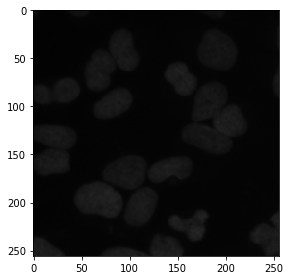

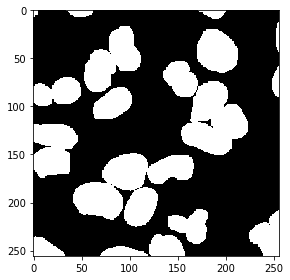

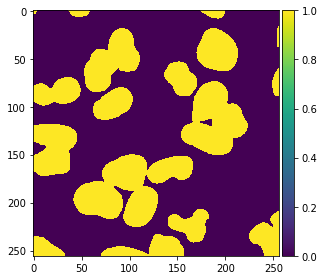

In [9]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

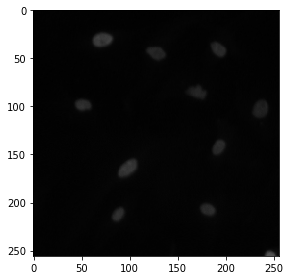

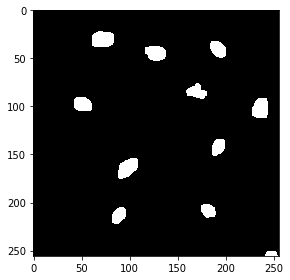

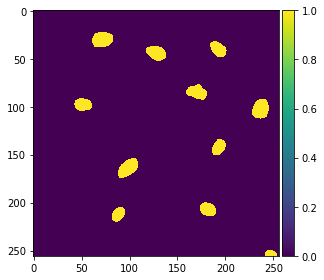

In [10]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [11]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [12]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))


In [14]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

fname ='sub-dsbowl nep '+str(n_epochs)+' vsplit '+str(val_split)+' seed '+str(seed)+'.csv'

sub.to_csv(fname, index=False)

nm=(time.time() - start_time)/60
print ("Total time %s min" % nm)

Total time 51.03700505495071 min
